In [2]:
import sys
import os
project_path = os.path.abspath('..')  # Chemin vers le dossier parent
sys.path.append(project_path)
from utils import loaders_by_classes, filter_loaders, balance, balanced_batch_size, submodel, get_activations
from classNets import ConvNet, SondeNet

import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_workers = os.cpu_count()

device, num_workers

(device(type='mps'), 12)

In [ ]:
model_all_class = torch.load('./models/all_class.pth', weights_only=False)

# Choose class to unlearn

In [ ]:
class_num = 7
class_name = '7 - seven'
model = submodel(model_all_class, class_num)
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

# Load Datasets

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
batch_size = 64
train_loaders = loaders_by_classes(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loaders = loaders_by_classes(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
loaders = train_loaders
loaders

{'0 - zero': <torch.utils.data.dataloader.DataLoader at 0x30e176db0>,
 '1 - one': <torch.utils.data.dataloader.DataLoader at 0x30e098710>,
 '2 - two': <torch.utils.data.dataloader.DataLoader at 0x30e197a40>,
 '3 - three': <torch.utils.data.dataloader.DataLoader at 0x30e283e90>,
 '4 - four': <torch.utils.data.dataloader.DataLoader at 0x30e283ef0>,
 '5 - five': <torch.utils.data.dataloader.DataLoader at 0x30e24a000>,
 '6 - six': <torch.utils.data.dataloader.DataLoader at 0x30e2a0a40>,
 '7 - seven': <torch.utils.data.dataloader.DataLoader at 0x30e2a11f0>,
 '8 - eight': <torch.utils.data.dataloader.DataLoader at 0x30e2a1070>,
 '9 - nine': <torch.utils.data.dataloader.DataLoader at 0x30e2a1220>}

In [ ]:
blcd_batch_size = int(batch_size * balanced_batch_size(loaders, class_name))
blcd_batch_size

484

In [ ]:
forget_loader = loaders[class_name]
retain_loader = filter_loaders(loaders, class_name, blcd_batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
retain_input = next(iter(retain_loader))
r_input_tensor, r_label_tensor = retain_input[0].to(device), retain_input[1].to(device)
forget_input = next(iter(forget_loader))
f_input_tensor, f_label_tensor = forget_input[0].to(device), forget_input[1].to(device)
criterion = torch.nn.CrossEntropyLoss()

r_label_tensor = r_label_tensor - 1 * (r_label_tensor > class_num)
loss = criterion(model(r_input_tensor), r_label_tensor)
loss

tensor(0.0225, device='mps:0', grad_fn=<NllLossBackward0>)

In [ ]:
def get_softmax(model, n_batch = 10):
    """
    Get rpz of forget wrt to retain
    Just at the init
    """
    softmax = 0
    for i_batch in range(n_batch):
        input_tensor = next(iter(forget_loader))
        softmax += torch.exp(model(input_tensor[0].to(device)))
    softmax = softmax / n_batch
    return softmax.mean(dim=0)

def convex_target(softmax, activations, labels):
    """
    softmax : from forget rpz wrt to retain
    activations : residues of retain
    """
    target = 0
    activations_dict = {}
    for idx, _label in enumerate(labels):
        label = int(_label.item())
        if label not in activations_dict.keys():
            activations_dict[label] = {}
            activations_dict[label]['activation'] = activations[idx, :].clone()
            activations_dict[label]['count'] = 1
        else:
            activations_dict[label]['activation'] += activations[idx, :]
            activations_dict[label]['count'] += 1

    for key, dval in activations_dict.items():
        ikey = key - 1 * (key > class_num)
        target += softmax[ikey] * dval['activation'] / dval['count']
    
    return target

def masked_grads(forget_grads, retain_grads, Masks):
    masks = []
    m_grads = []
    for idx_param, f_grad in enumerate(forget_grads):
        r_grad = retain_grads[idx_param]
        mask = f_grad * r_grad > 0
        if len(Masks) <= idx_param:
            masks.append(mask)
        else:
            masks.append(mask * Masks[idx_param])
        # /!\/!\/!\
        # Formule du gradient pour la descente
        m_grad = masks[idx_param] * f_grad * torch.abs(r_grad)
        # /!\/!\/!\
        m_grads.append(m_grad)
    return m_grads, masks

def update_param(model, forget_grads, retain_grads, Masks = []):
    m_grads, masks = masked_grads(forget_grads, retain_grads, Masks)
    max_perc_param = 0.
    for idx_param, param in enumerate(model.parameters()):
        param.grad = m_grads[idx_param]
        perc_param = 100 * torch.sum(param.grad > 0)/torch.tensor(param.size()).prod()
        if perc_param > max_perc_param:
            max_perc_param = perc_param
    return max_perc_param, masks

def get_grads(model, softmax, forget_input, retain_input, device=device, verbose=False):
    r_input_tensor, r_label_tensor = retain_input[0].to(device), retain_input[1].to(device)
    # Attention !
    # On a retiré une classe
    r_label_tensor = r_label_tensor - 1 * (r_label_tensor > class_num)
    # ^^^ /!\ ^^^
    f_input_tensor, _ = forget_input[0].to(device), forget_input[1].to(device)

    # get r_grads
    model.zero_grad()
    r_input_tensor.requires_grad = True
    retain_dict = get_activations(model, r_input_tensor, -1, verbose=verbose)

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(retain_dict['output'], r_label_tensor)
    loss.backward()

    r_grads = []
    for param in model.parameters():
        r_grads.append(param.grad)

    # get f_grads
    model.zero_grad()
    f_input_tensor.requires_grad = True
    forget_dict = get_activations(model, f_input_tensor, -1, verbose=verbose)

    r_activations = retain_dict['activations'].detach()
    target = convex_target(softmax, r_activations, r_label_tensor)

    criterion = torch.nn.MSELoss()
    loss = criterion(torch.mean(forget_dict['activations'], dim=0), target)
    loss.backward()

    f_grads = []
    for param in model.parameters():
        f_grads.append(param.grad)
    
    return f_grads, r_grads

def unlearn_step(model, softmax, forget_input, retain_input, optimizer, device=device, Masks=[]):
    optimizer.zero_grad()
    f_grads, r_grads = get_grads(model, softmax, forget_input, retain_input, verbose=False)
    max_perc_param, masks = update_param(model, f_grads, r_grads, Masks=Masks)
    optimizer.step()
    return max_perc_param, masks

def untrain(model, softmax, device, forget_loader, retain_loader, optimizer, epochs=1, tau=0.):
    for epoch in range(epochs):
        masks=[]
        forget_iter_loader = iter(forget_loader)
        for batch_idx, retain_input in enumerate(retain_loader):
            try:
                forget_input = next(forget_iter_loader)
            except:
                break
            max_perc_param, masks = unlearn_step(model, softmax, forget_input, retain_input, optimizer, device=device, Masks=masks)
            if max_perc_param == 0.:
                break
            if batch_idx % 10 == 0:
                print(max_perc_param)
                print(f'{batch_idx} / {len(retain_loader)}')
            if batch_idx == None:
                break
        print(max_perc_param)

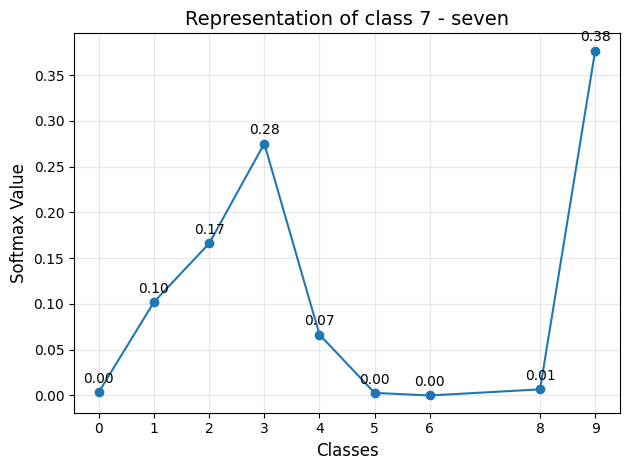

In [ ]:

softmax = get_softmax(model).detach()
plt.title(f'Representation of class {class_name}')
tx = np.arange(10)
tx = np.concatenate([tx[:class_num],tx[1+class_num:]])
# Création du graphique
plt.title(f'Representation of class {class_name}', fontsize=14)
ty = softmax.cpu().numpy()
plt.plot(tx, ty, marker='o', label='Classes')

# Annotation des points
for i, (x, y) in enumerate(zip(tx, ty)):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', fontsize=10)

# Ajout des axes et personnalisation
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Softmax Value", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(tx)
plt.tight_layout()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
untrain(model, softmax, device, forget_loader, retain_loader, optimizer, epochs = 10)

tensor(43.7500, device='mps:0')
0 / 112
tensor(0.1790, device='mps:0')
10 / 112
0.0
tensor(19.6506, device='mps:0')
0 / 112
tensor(0.0868, device='mps:0')
10 / 112
0.0
tensor(45.3125, device='mps:0')
0 / 112
tensor(0.1736, device='mps:0')
10 / 112
tensor(0.0002, device='mps:0')
20 / 112
0.0
tensor(38.1944, device='mps:0')
0 / 112
tensor(0.0326, device='mps:0')
10 / 112
0.0
tensor(32.5304, device='mps:0')
0 / 112
tensor(0.3906, device='mps:0')
10 / 112
0.0
tensor(35.9375, device='mps:0')
0 / 112
tensor(0.2116, device='mps:0')
10 / 112
tensor(0.0005, device='mps:0')
20 / 112
0.0
tensor(34.1309, device='mps:0')
0 / 112
tensor(0.1519, device='mps:0')
10 / 112
tensor(0.0760, device='mps:0')
20 / 112
0.0
tensor(35.9375, device='mps:0')
0 / 112
tensor(0.3472, device='mps:0')
10 / 112
tensor(0.0054, device='mps:0')
20 / 112
0.0
tensor(26.6819, device='mps:0')
0 / 112
tensor(0.4991, device='mps:0')
10 / 112
tensor(0.0434, device='mps:0')
20 / 112
0.0
tensor(26.5625, device='mps:0')
0 / 112
tens

In [ ]:
torch.exp(model(r_input_tensor))

tensor([[1.5859e-07, 1.3565e-10, 1.0867e-06,  ..., 4.2555e-07, 1.0000e+00,
         1.9279e-11],
        [9.2862e-03, 1.5424e-03, 6.1453e-07,  ..., 9.8796e-01, 6.7983e-04,
         2.5578e-07],
        [9.3557e-08, 9.9997e-01, 1.9880e-05,  ..., 1.3859e-06, 2.6101e-06,
         2.4812e-09],
        ...,
        [3.4308e-08, 1.6650e-07, 8.2612e-09,  ..., 1.7321e-09, 8.9984e-04,
         9.9587e-01],
        [6.3321e-08, 4.1278e-10, 7.7174e-07,  ..., 7.3159e-09, 1.0000e+00,
         4.5935e-09],
        [1.1648e-09, 7.4018e-08, 2.2281e-07,  ..., 1.0666e-10, 2.1353e-04,
         6.7996e-05]], device='mps:0', grad_fn=<ExpBackward0>)

In [ ]:
print(f'previous loss : {loss}')
loss = criterion(model(r_input_tensor), r_label_tensor)
print(f'unlearned model loss : {loss}')

previous loss : 0.02251450903713703
unlearned model loss : 0.027320783585309982


# Sonde Attack

In [ ]:
sondeNet = SondeNet()
sondeNet.to(device)
sondeNet

SondeNet(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loaders = test_loaders
loaders

{'0 - zero': <torch.utils.data.dataloader.DataLoader at 0x30e2a1250>,
 '1 - one': <torch.utils.data.dataloader.DataLoader at 0x30e2a13a0>,
 '2 - two': <torch.utils.data.dataloader.DataLoader at 0x30e2a12e0>,
 '3 - three': <torch.utils.data.dataloader.DataLoader at 0x30e2a14f0>,
 '4 - four': <torch.utils.data.dataloader.DataLoader at 0x30e2a15b0>,
 '5 - five': <torch.utils.data.dataloader.DataLoader at 0x30e2a1670>,
 '6 - six': <torch.utils.data.dataloader.DataLoader at 0x30e2a1730>,
 '7 - seven': <torch.utils.data.dataloader.DataLoader at 0x30e2a17f0>,
 '8 - eight': <torch.utils.data.dataloader.DataLoader at 0x30e2a18b0>,
 '9 - nine': <torch.utils.data.dataloader.DataLoader at 0x30e2a1970>}

# Create SondeNet Loader

In [ ]:
model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
model_no_ = torch.load('./models/no_7 - seven.pth', weights_only=False)
class_num = 7
class_name = '7 - seven'
model_no_seven = submodel(model_no_, class_num)
model_no_seven.to(device)
model_no_seven.eval()

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

forget_loader = loaders[class_name]
retain_loader = filter_loaders(loaders, class_name, batch_size, shuffle=True, num_workers=num_workers)

def sonde_activations(model, data, device=device):
    input = data[0].to(device)
    return get_activations(model, input, layer_num=-2, verbose=False)['activations']

# Fonction pour appliquer my_func et associer les labels
def create_combined_dataset(model, forget_loader, retain_loader, my_func):
    combined_data = []
    combined_labels = []

    # Process data from forget_loader
    n = 0
    for data in forget_loader:
        with torch.no_grad():
            processed_data = my_func(model, data)
        combined_data.append(processed_data)
        combined_labels.append(torch.ones(len(processed_data)))  # Label 1 for forget_loader
        n += 1

    # Process data from retain_loader
    for i, data in enumerate(retain_loader):
        with torch.no_grad():
            processed_data = my_func(model, data)
        combined_data.append(processed_data)
        combined_labels.append(torch.zeros(len(processed_data)))  # Label 0 for retain_loader
        if i == n-1:
            break

    # Flatten lists and convert to tensors
    combined_data = torch.cat(combined_data)
    combined_labels = torch.cat(combined_labels)

    return torch.utils.data.TensorDataset(combined_data, combined_labels)

# Création du DataLoader combiné
def create_combined_dataloader(model, forget_loader, retain_loader, my_func, batch_size, shuffle=True, num_workers=0):
    combined_dataset = create_combined_dataset(model, forget_loader, retain_loader, my_func)
    return DataLoader(combined_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Exemple d'utilisation
# forget_loader et retain_loader doivent déjà être définis
# my_func doit être une fonction prenant des données en entrée et retournant des données transformées
batch_size = 32
num_workers = 4
sonde_loader = create_combined_dataloader(
    model=model_no_seven,
    forget_loader=forget_loader,
    retain_loader=retain_loader,
    my_func=sonde_activations,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Définition de la fonction d'entraînement
def train_sondeNet(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model = model.to(device)  # Envoyer le modèle sur l'appareil (CPU ou GPU)
    model.train()  # Mettre le modèle en mode entraînement
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Boucle sur le DataLoader
        for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Réinitialiser les gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()  # Assurez-vous que la sortie est de la bonne forme
            loss = criterion(outputs, labels)

            # Backward pass et mise à jour des poids
            loss.backward()
            optimizer.step()

            # Calcul des métriques
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()  # Seuil pour prédire 0 ou 1
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Affichage des statistiques d'entraînement
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(dataloader):.4f} - Accuracy: {accuracy:.2f}%")

    print("Entraînement terminé.")

# Préparation du modèle, de la fonction de perte et de l'optimiseur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sondeNet = sondeNet.to(device)  # Assurez-vous que votre modèle `sondeNet` est correctement défini
criterion = nn.MSELoss()  # Perte binaire pour les sorties scalaires entre 0 et 1
optimizer = optim.Adam(sondeNet.parameters(), lr=0.001)

# Lancer l'entraînement
train_sondeNet(sondeNet, sonde_loader, criterion, optimizer, device, num_epochs=5)

Epoch 1/5: 100%|██████████| 294/294 [00:00<00:00, 977.88it/s]


Epoch 1/5 - Loss: 0.0221 - Accuracy: 97.18%


Epoch 2/5: 100%|██████████| 294/294 [00:00<00:00, 1082.43it/s]


Epoch 2/5 - Loss: 0.0085 - Accuracy: 98.94%


Epoch 3/5: 100%|██████████| 294/294 [00:00<00:00, 1033.94it/s]


Epoch 3/5 - Loss: 0.0079 - Accuracy: 98.99%


Epoch 4/5: 100%|██████████| 294/294 [00:00<00:00, 1092.51it/s]


Epoch 4/5 - Loss: 0.0057 - Accuracy: 99.18%


Epoch 5/5: 100%|██████████| 294/294 [00:00<00:00, 1092.24it/s]

Epoch 5/5 - Loss: 0.0050 - Accuracy: 99.37%
Entraînement terminé.


In [ ]:
# output of sondeNet
data = next(iter(sonde_loader))
input_tensor, label_tensor = data[0].to(device), data[1].to(device)
output_tensor = sondeNet(input_tensor)
output_tensor

tensor([[9.9997e-01],
        [9.9995e-01],
        [9.9988e-01],
        [1.1254e-08],
        [9.9996e-01],
        [9.9986e-01],
        [9.9996e-01],
        [9.9989e-01],
        [9.9999e-01],
        [6.7562e-05],
        [9.9994e-01],
        [5.7248e-02],
        [5.1010e-07],
        [5.1280e-04],
        [9.9843e-01],
        [9.9781e-01],
        [9.9981e-01],
        [1.1888e-03],
        [9.9994e-01],
        [2.1434e-07],
        [9.9997e-01],
        [5.4119e-04],
        [2.6281e-02],
        [9.9990e-01],
        [9.9993e-01],
        [9.9999e-01],
        [9.8229e-01],
        [1.0000e+00],
        [9.9995e-01],
        [9.9999e-01],
        [9.9997e-01],
        [1.7024e-01]], grad_fn=<SigmoidBackward0>)

In [ ]:
from MIA import MIA

In [ ]:


retain_loader_train = filter_loaders(train_loaders, class_name, blcd_batch_size, shuffle=True, num_workers=num_workers)
retain_loader_test = filter_loaders(train_loaders, class_name, blcd_batch_size, shuffle=True, num_workers=num_workers)
forget_loader = train_loaders[class_name]
test_loader = test_loaders[class_name]

In [ ]:
model.to(device)
model(next(iter(forget_loader))[0])

tensor([[-1.2840e+01, -9.3497e-01, -3.4790e+00, -9.9765e-01, -3.8078e+00,
         -8.0533e+00, -1.4141e+01, -6.5656e+00, -1.6934e+00],
        [-1.0131e+01, -6.1081e+00, -9.6205e-01, -6.0457e-01, -8.8311e+00,
         -1.2513e+01, -1.9205e+01, -7.9562e+00, -2.6763e+00],
        [-9.2549e+00, -2.9199e+00, -4.4353e-01, -2.3269e+00, -3.5900e+00,
         -9.8361e+00, -1.3507e+01, -4.9451e+00, -1.7612e+00],
        [-9.0292e+00, -3.5210e+00, -6.7557e-02, -3.4083e+00, -1.4734e+01,
         -1.1903e+01, -1.8423e+01, -6.1598e+00, -7.7794e+00],
        [-1.0147e+01, -4.7987e+00, -3.6827e+00, -8.9919e-01, -3.7961e+00,
         -9.0383e+00, -1.5711e+01, -9.3950e+00, -6.2175e-01],
        [-1.0297e+01, -7.3394e+00, -1.6268e-02, -5.0318e+00, -2.1615e+01,
         -1.3947e+01, -2.0385e+01, -4.7203e+00, -1.1257e+01],
        [-1.6751e+01, -4.2824e+00, -2.7923e+00, -4.2472e-01, -1.4482e+00,
         -9.8735e+00, -1.2741e+01, -3.3360e+00, -7.9891e+00],
        [-3.2651e+00, -8.7481e+00, -5.9322e-01, 

In [ ]:
model.to(device)

MIA(
    retain_loader_train, 
    retain_loader_test, 
    forget_loader, 
    test_loader, 
    model, 
    device
)

IndexError: index 9 is out of bounds for axis 1 with size 9